## AIDA reactive experiments

In [9]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
import ProgressMeter
using WAV
using Plots

In [10]:
@marginalrule typeof(+)(:in1_in2) (m_out::UnivariateNormalDistributionsFamily, m_in1::UnivariateNormalDistributionsFamily, m_in2::UnivariateNormalDistributionsFamily) = begin
    xi_out = weightedmean(m_out)
    W_out  = precision(m_out)
    xi_in1 = weightedmean(m_in1)
    W_in1  = precision(m_in1)
    xi_in2 = weightedmean(m_in2)
    W_in2  = precision(m_in2)
    
    return MvNormalWeightedMeanPrecision([xi_in1+xi_out; xi_in2+xi_out], [W_in1+W_out W_out; W_out W_in2+W_out])
end

@rule typeof(+)(:in1, Marginalisation) (m_out::UnivariateNormalDistributionsFamily, m_in2::UnivariateNormalDistributionsFamily) = begin
    return NormalMeanVariance(mean(m_out) - mean(m_in2), var(m_out) + var(m_in2))
end
@rule typeof(+)(:in2, Marginalisation) (m_out::UnivariateNormalDistributionsFamily, m_in1::UnivariateNormalDistributionsFamily) = begin
    return NormalMeanVariance(mean(m_out) - mean(m_in1), var(m_out) + var(m_in1))
end

In [11]:
include("helpers/aida_segmentation.jl")
include("helpers/aida_snr.jl")

SNR (generic function with 1 method)

In [12]:
# Auxilary "pure" AR model
@model function ar_model(n, order)

    x = datavar(Vector{Float64}, n)
    y = datavar(Float64, n)

    γ ~ GammaShapeRate(1.0, 1.0) where {q=MeanField()}
    θ ~ MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)) where {q=MeanField()}


    for i in 1:n
        y[i] ~ NormalMeanPrecision(dot(x[i], θ), γ) where {q=MeanField()}
    end

    return x, y, θ, γ
end

function inference_ar(inputs, outputs, order, niter)
    n = length(outputs)
    model, (x, y, θ, γ) = ar_model(n, order, options = (limit_stack_depth = 500, ))

    γ_buffer = nothing
    θ_buffer = nothing
    fe = Vector{Float64}()

    γsub = subscribe!(getmarginal(γ), (my) -> γ_buffer = my)
    θsub = subscribe!(getmarginal(θ), (mθ) -> θ_buffer = mθ)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))

    setmarginal!(γ, GammaShapeRate(1.0, 1.0))

    ProgressMeter.@showprogress for i in 1:niter
        update!(x, inputs)
        update!(y, outputs)
    end


    return γ_buffer, θ_buffer, fe
end

function ar_ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ar_ssm (generic function with 1 method)

In [13]:
# Auxilary model to infer stationary noise variance
@model function gaussian_model(n)

    y = datavar(Float64, n)

    γ   ~ GammaShapeRate(1.0, 1.0) where {q=MeanField()}
    x_0 ~ NormalMeanPrecision(0.0, 1.0) where {q=MeanField()}
    x   ~ NormalMeanPrecision(x_0, γ) where {q=MeanField()}

    for i in 1:n
        y[i] ~ NormalMeanPrecision(x, 1e4) where {q=MeanField()}
    end

    return y, x, γ
end

function inference_gaussian(outputs, niter)
    n = length(outputs)
    model, (y, x, γ) = gaussian_model(n, options = (limit_stack_depth = 500, ))
    γ_buffer = nothing
    x_buffer = nothing
    fe = Vector{Float64}()

    γsub = subscribe!(getmarginal(γ), (my) -> γ_buffer = my)
    xsub = subscribe!(getmarginal(x), (mx) -> x_buffer = mx)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))

    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(x, NormalMeanPrecision(0.0, 1.0))

    ProgressMeter.@showprogress for i in 1:niter
        update!(y, outputs)
    end

    unsubscribe!(γsub)
    unsubscribe!(xsub)
    unsubscribe!(fesub)

    return x_buffer, γ_buffer, fe
end

inference_gaussian (generic function with 1 method)

### Simple LAR model to infer parameters of audio signal

In [14]:
@model function lar_model(n, order, artype, c, τ)

    x = randomvar(n)
    y = datavar(Float64, n)
    ct  = constvar(c)

    γ ~ GammaShapeRate(1.0, 1e-4) where {q=MeanField()}
    θ ~ MvNormalMeanPrecision(randn(order), Matrix{Float64}(I, order, order)) where {q=MeanField()}
    x0 ~ MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)) where {q=MeanField()}

    x_prev = x0

    ar_nodes = Vector{FactorNode}(undef, n)

    for i in 1:n
        ar_nodes[i], x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = ARMeta(artype, order, ARsafe()) }

        y[i] ~ NormalMeanVariance(dot(ct, x[i]), τ)

        x_prev = x[i]
    end

    return y, x, θ, γ, ar_nodes
end

lar_model (generic function with 1 method)

In [15]:
function lar_inference(data, order, niter, τ)
    n = length(data)
    artype = Multivariate
    c = zeros(order); c[1] = 1.0
    model, (y, x, θ, γ, ar_nodes) = lar_model(n, order, artype, c, τ)

    γ_buffer = nothing
    θ_buffer = nothing
    x_buffer = Vector{Marginal}(undef, n)
    fe = Vector{Float64}()

    γsub = subscribe!(getmarginal(γ), (mγ) -> γ_buffer = mγ)
    θsub = subscribe!(getmarginal(θ), (mθ) -> θ_buffer = mθ)
    xsub = subscribe!(getmarginals(x), (mx) -> copyto!(x_buffer, mx))
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))

    setmarginal!(γ, GammaShapeRate(1.0, 1e-4))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)))

    for i in 1:n
        setmarginal!(ar_nodes[i], :y_x, MvNormalMeanPrecision(zeros(2*order), Matrix{Float64}(I, 2*order, 2*order)))
    end
    for i in 1:niter
        update!(y, data)
    end
    return γ_buffer, θ_buffer, x_buffer, fe
end

lar_inference (generic function with 1 method)

In [16]:
# to optimize
function lar_batch_learning(segments, ar_order, vmp_its, τ)
    totseg = size(segments, 1)
    l      = size(segments, 2)
    
    rmx = zeros(totseg, l)
    rvx = zeros(totseg, l)
    rmθ = zeros(totseg, ar_order)
    rvθ = zeros(totseg, ar_order, ar_order)
    rγ = fill(tuple(.0, .0), totseg)
    fe  = zeros(totseg, vmp_its)
    
    ProgressMeter.@showprogress for segnum in 1:totseg
        γ, θ, xs, fe[segnum, :] = lar_inference(segments[segnum, :], ar_order, vmp_its, τ)

        mx, vx                            = mean.(xs), cov.(xs)
        mθ, vθ                            = mean(θ), cov(θ)
        rmx[segnum, :], rvx[segnum, :]    = first.(mx), first.(vx)
        rmθ[segnum, :], rvθ[segnum, :, :] = mθ, vθ
        rγ[segnum]                        = shape(γ), rate(γ)
    end
    rmx, rvx, rmθ, rvθ, rγ
end

lar_batch_learning (generic function with 1 method)

In [198]:
# load clean speech
cl, fs = wavread("sound/speech/sp02.wav");

In [124]:
cl_seg = get_frames(cl, fs)
cmx, cvx, cmθ, cvθ, cγ = lar_batch_learning(cl_seg, 10, 10, 1e-12);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:59


In [18]:
# load bar sound
br, fs = wavread("sound/environment/bar.wav");

In [130]:
br_seg = get_frames(br, fs)
bmx, bvx, bmθ, bvθ, bγ = lar_batch_learning(br_seg, 2, 10, 1e-12);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


In [48]:
mean(bmθ, dims=1)

1×2 Matrix{Float64}:
 1.25137  -0.423889

In [52]:
bγ[end][1]/bγ[end][2]

80379.2421157681

In [11]:
x, γ, fe = inference_gaussian(reshape(br, (size(br, 1), )), 100)
mx, vx = mean(x), cov(x)
mγ = mean(γ)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


1.2247448686871325

In [103]:
ar_order = 2
from = 1
to = 1000
inputs, outputs = ar_ssm(br[from:1:to], ar_order)
γ, θ, fe = inference_ar(inputs, outputs, ar_order, 10)
println(mean(θ), "\t", mean(γ))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


[1.2410255625374482, -0.40818939640320684]	495.2305552322242


In [ ]:
[1.1771722596241831, -0.21515333240765416, -0.013241102782644981, -0.3439220201874813, 0.18954964075486896, 0.1719459819444345, -0.020872038528430753, -0.16814736936466246, -0.0832522436253964, 0.10765449466835753]	488.9721289090303

In [ ]:
plot(br[1:10:end])

In [23]:
# load kids sound
kr, fs = wavread("sound/environment/kids.wav");

In [31]:
kr_seg = get_frames(kr, fs)
kmx, kvx, kmθ, kvθ, kγ = lar_batch_learning(kr_seg, 2, 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


In [13]:
x, γ, fe = inference_gaussian(reshape(kr, (size(kr, 1), )), 100)
mx, mx = mean(x), cov(x)
mγ = mean(γ)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


1.224744867879589

In [31]:
ar_order = 10
from = 1
to = 1000
inputs, outputs = ar_ssm(kr[from:1:to], ar_order)
γ, θ, fe = inference_ar(inputs, outputs, ar_order, 10)
println(mean(θ), "\t", mean(γ))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


[1.7165319559487267, -1.64270847035433, 0.802828694609524, -0.33360693559957255, 0.35995451371455345, -0.5373125263912328, 0.32263370988818707, 0.10161316241022789, -0.41096272296658665, 0.3107576822568615]	445.96526744163975


In [15]:
# load forest sound
fr, fs = wavread("sound/environment/forest.wav");

In [83]:
fr_seg = get_frames(fr, fs)
frmx, frvx, frmθ, frvθ, frγ = batch_learning(fr_seg, 5, 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


In [19]:
ar_order = 2
inputs, outputs = ar_ssm(fr[1:10:end], ar_order)
γ, θ, fe = inference_ar(inputs, outputs, ar_order, 10)
println(mean(θ), "\t", mean(γ))

Progress: 100%|█████████████████████████████████████████| Time: 0:04:25


[0.8736889491613922, -0.1749365872955999]	957.349073007666


In [72]:
ar_order = 2
inputs, outputs = ar_ssm(fr[1:100:end], ar_order)
γ, θ, fe = inference_ar(inputs, outputs, ar_order, 10)
println(mean(θ), "\t", mean(γ))

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[-0.20323649754037096, -0.13362197085378788]	102.9944354972934


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [61]:
# train sound
tr, fs = wavread("sound/environment/train.wav")
tr_seg = get_frames(tr, fs)
trmx, trvx, trmθ, trvθ, trγ = batch_learning(tr_seg, 5, 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


In [82]:
ar_order = 10
inputs, outputs = ar_ssm(tr[1:10:end], ar_order)
γ, θ, fe = inference_ar(inputs, outputs, ar_order, 10)
println(mean(θ), "\t", mean(γ))

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[0.05580275684828447, -0.06971276403550794, 0.03605368101506624, -0.12498182953809668, -0.0849619878863063, 0.10622721636016212, 0.15419279043573297, -0.04245459143726561, -0.16477088656525696, 0.07056581449065422]	92.28078085307476


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


# Mixed sounds

In [32]:
# mixed scene
bob, fs = wavread("sound/mixed/bar_speech.wav")
# plot(bob)
bob_seg = get_frames(bob, fs, len_sec=0.01, overlap_sec=0.002)
bobmx, bobvx, bobmθ, bobvθ, bobγ = lar_batch_learning(bob_seg, 10, 10, 1e-3);

Progress:   7%|██▉                                      |  ETA: 0:01:41

LoadError: InterruptException:

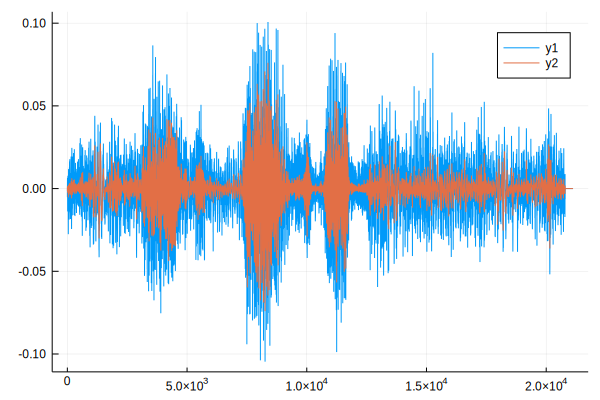

In [13]:
plot(get_signal(bob_seg, fs, len_sec=0.01, overlap_sec=0.002))
plot!(get_signal(bobmx, fs, len_sec=0.01, overlap_sec=0.002))

## Coupled model (AR speech + AR noise)

In [131]:
struct InitARMessages{M} <: ReactiveMP.AbstractPipelineStage 
    message :: M
end
ReactiveMP.apply_pipeline_stage(stage::InitARMessages, factornode, tag::Type{Val{:x}}, stream) = stream |> start_with(Message(stage.message, false, true))
ReactiveMP.apply_pipeline_stage(stage::InitARMessages, factornode, tag::Type{Val{:y}}, stream) = stream |> start_with(Message(stage.message, false, true))
ReactiveMP.apply_pipeline_stage(stage::InitARMessages, factornode, tag, stream)                = stream

In [171]:
@model function coupled_model(n, prior_η, prior_τ, order_1, order_2, artype, c1, c2)

    # z for ar_1
    z  = randomvar(n)
    z1 = randomvar(n)
    # x for ar_2
    x  = randomvar(n)
    x1 = randomvar(n)
    o = datavar(Float64, n)
    
    ct1  = constvar(c1)
    ct2  = constvar(c2)
    
    # AR_1
    γ ~ GammaShapeRate(1.0, 1e-4) where {q=MeanField()}
    θ ~ MvNormalMeanPrecision(zeros(order_1), Matrix{Float64}(I, order_1, order_1)) where {q=MeanField()}
    z0 ~ MvNormalMeanPrecision(zeros(order_1), Matrix{Float64}(I, order_1, order_1)) where {q=MeanField()}
    
    # AR_2
    τ ~ GammaShapeRate(prior_τ[1], prior_τ[2]) where {q=MeanField()}
    η ~ MvNormalMeanPrecision(prior_η[1], 1e12*Matrix{Float64}(I, order_2, order_2)) where {q=MeanField()}
#     η ~ MvNormalMeanPrecision(prior_η[1], prior_η[2]) where {q=MeanField()}
    x0 ~ MvNormalMeanPrecision(zeros(order_2), 1e2*Matrix{Float64}(I, order_2, order_2)) where {q=MeanField()}

    z_prev = z0
    x_prev = x0

    ar_1_nodes = Vector{FactorNode}(undef, n)
    ar_2_nodes = Vector{FactorNode}(undef, n)

    for i in 1:n
        ar_1_nodes[i], z[i] ~ AR(z_prev, θ, γ) where { 
            q = q(y, x)q(γ)q(θ), meta = ARMeta(artype, order_1, ARsafe()), 
            pipeline = InitARMessages(MvNormalMeanPrecision(zeros(order_1), Matrix{Float64}(I, order_1, order_1)))
        }
        z1[i] ~ dot(ct1, z[i])
        
        ar_2_nodes[i], x[i] ~ AR(x_prev, η, τ) where { 
            q = q(y, x)q(γ)q(θ), meta = ARMeta(artype, order_2, ARsafe()) ,
            pipeline = InitARMessages(MvNormalMeanPrecision(zeros(order_2), Matrix{Float64}(I, order_2, order_2)))
        }
        x1[i] ~ dot(ct2, x[i])
        
        o[i] ~ NormalMeanVariance(z1[i] + x1[i], 1e-12)

        x_prev = x[i]
        z_prev = z[i]
    end
    
    scheduler = schedule_updates(x, θ, γ, z, η, τ)

    return o, z, z1, θ, γ, x, x1, η, τ, ar_1_nodes, ar_2_nodes, scheduler
end

coupled_model (generic function with 1 method)

In [172]:
function coupled_inference(data, prior_η, prior_τ, order_1, order_2, niter)
    n = length(data)
    artype = Multivariate
    c1 = zeros(order_1); c1[1] = 1.0
    c2 = zeros(order_2); c2[1] = 1.0
    model, (o, z, z1, θ, γ, x, x1, η, τ, ar_1_nodes, ar_2_nodes, scheduler) = coupled_model(n, prior_η, prior_τ, order_1, order_2, artype, c1, c2, options=(limit_stack_depth=100, ))

    γ_buffer = nothing
    θ_buffer = nothing
    x_buffer = Vector{Marginal}(undef, n)
    
    τ_buffer = nothing
    η_buffer = nothing
    z_buffer = Vector{Marginal}(undef, n)
    fe = Vector{Float64}()

    γsub = subscribe!(getmarginal(γ), (mγ) -> γ_buffer = mγ)
    θsub = subscribe!(getmarginal(θ), (mθ) -> θ_buffer = mθ)
    xsub = subscribe!(getmarginals(x), (mx) -> copyto!(x_buffer, mx))
    
    τsub = subscribe!(getmarginal(τ), (mτ) -> τ_buffer = mτ)
    ηsub = subscribe!(getmarginal(η), (mη) -> η_buffer = mη)
    zsub = subscribe!(getmarginals(z), (mz) -> copyto!(z_buffer, mz))
    
    fe_scheduler = PendingScheduler()
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model, fe_scheduler), (f) -> push!(fe, f))
    setmarginal!(γ, GammaShapeRate(1e-12, 1e-12))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order_1), Matrix{Float64}(I, order_1, order_1)))
    
    setmarginal!(τ, GammaShapeRate(prior_τ[1], prior_τ[2]))
#     setmarginal!(η, MvNormalMeanPrecision(prior_η[1], prior_η[2])) # better
    setmarginal!(η, MvNormalMeanPrecision(prior_η[1],  1e4*Matrix{Float64}(I, order_2, order_2)))

    for i in 1:n
#         setmarginal!(x1[i], NormalMeanPrecision(0.0, 1.0))
#         setmarginal!(z1[i], NormalMeanPrecision(0.0, 1.0))
        setmarginal!(ar_1_nodes[i], :y_x, MvNormalMeanPrecision(zeros(2*order_1), Matrix{Float64}(I, 2*order_1, 2*order_1)))
        setmarginal!(ar_2_nodes[i], :y_x, MvNormalMeanPrecision(zeros(2*order_2), Matrix{Float64}(I, 2*order_2, 2*order_2)))
    end
    
    for i in 1:niter
        update!(o, data)
        # iffy approach
        for i in 1:n
            release!(scheduler)
        end
        release!(fe_scheduler)
    end
    return γ_buffer, θ_buffer, z_buffer, τ_buffer, η_buffer, x_buffer, fe
end

coupled_inference (generic function with 1 method)

In [173]:
function batch_coupled_learning(segments, priors_η, priors_τ, ar_1_order, ar_2_order, vmp_its)
    totseg = size(segments, 1)
    l      = size(segments, 2)
    rmx = zeros(totseg, l)
    rvx = zeros(totseg, l)
    rmθ = zeros(totseg, ar_1_order)
    rvθ = zeros(totseg, ar_1_order, ar_1_order)
    rγ = fill(tuple(.0, .0), totseg)
    
    rmz = zeros(totseg, l)
    rvz = zeros(totseg, l)
    rmη = zeros(totseg, ar_2_order)
    rvη = zeros(totseg, ar_2_order, ar_2_order)
    rτ = fill(tuple(.0, .0), totseg)
    
    fe  = zeros(totseg, vmp_its)
    
    ProgressMeter.@showprogress for segnum in 1:totseg
        prior_η                           = (priors_η[1][segnum, :], priors_η[2][segnum, :, :])
        prior_τ                           = priors_τ[segnum]
        γ, θ, zs, τ, η, xs, fe[segnum, :] = coupled_inference(segments[segnum, :], prior_η, prior_τ, ar_1_order, ar_2_order, vmp_its)
        mz, vz                            = mean.(zs), cov.(zs)
        mθ, vθ                            = mean(θ), cov(θ)
        rmz[segnum, :], rvz[segnum, :]    = first.(mz), first.(vz)
        rmθ[segnum, :], rvθ[segnum, :, :] = mθ, vθ
        rγ[segnum]                        = shape(γ), rate(γ)
        
        mx, vx                            = mean.(xs), cov.(xs)
        mη, vη                            = mean(η), cov(η)
        rmx[segnum, :], rvx[segnum, :]    = first.(mx), first.(vx)
        rmη[segnum, :], rvη[segnum, :, :] = mη, vη
        rτ[segnum]                        = shape(τ), rate(τ)
    end
    rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe
end

batch_coupled_learning (generic function with 1 method)

In [152]:
# get average priors from lar inference
prior_tau = bγ[end][1], bγ[end][2]
prior_eta = reshape(mean(bmθ, dims=1), (2,)), mean(bvθ, dims=1)[1, :, :]

([1.2511344281559542, -0.42332502294921964], [0.007442128526612844 -0.005597336396079403; -0.005597336396079403 0.0061455528410123])

In [153]:
# get time-varying priors from lar inference
priors_eta = (bmθ, bvθ[:, :, :])
priors_tau = bγ

352-element Vector{Tuple{Float64, Float64}}:
 (41.0, 0.0007373103229453854)
 (41.0, 0.0007954682852810857)
 (41.0, 0.0005485995666301553)
 (41.0, 0.0005972550908236589)
 (41.0, 0.0007769439380070497)
 (41.0, 0.0006516711467429892)
 (41.0, 0.00052633344109447)
 (41.0, 0.00044177626809542103)
 (41.0, 0.0006322706935061935)
 (41.0, 0.0008342261801840993)
 (41.0, 0.0007499519953241187)
 (41.0, 0.0006718285163556427)
 (41.0, 0.000713736428055708)
 ⋮
 (41.0, 0.0006369130649396547)
 (41.0, 0.0010702677835196283)
 (41.0, 0.001135565952785816)
 (41.0, 0.0014784970033831389)
 (41.0, 0.0014639122973268603)
 (41.0, 0.0012311289353997945)
 (41.0, 0.0007494627787514839)
 (41.0, 0.0007545194778154697)
 (41.0, 0.0007859064886458841)
 (41.0, 0.0008641182793003169)
 (41.0, 0.0007094434554524357)
 (41.0, 0.0005098339976995207)

In [142]:
totseg = 352
ar_order = 2
rmθ = zeros(totseg, ar_order)
rvθ = zeros(totseg, ar_order, ar_order)
for segnum in 1:totseg
    rmθ[segnum, :], rvθ[segnum, :, :] = mean(θ), cov(θ)
end
priors_eta = rmθ, rvθ
priors_tau = [params(γ) for _ in 1:352]

352-element Vector{Tuple{Float64, Float64}}:
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 ⋮
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)
 (500.0, 1.0096307562556177)

In [174]:
speech_bar, fs = wavread("sound/mixed/bar_speech.wav")
sb_seg = get_frames(speech_bar, fs)
rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe = batch_coupled_learning(sb_seg, priors_eta, priors_tau, 10, 2, 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:54


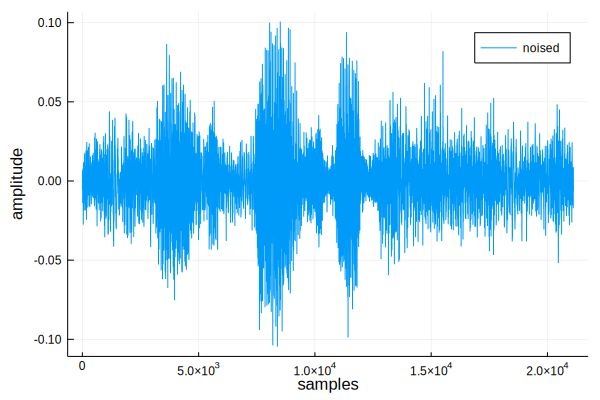

In [175]:
plot(speech_bar, ylabel="amplitude", xlabel="samples", label=:noised)
# plot!(cl, label=:clean)

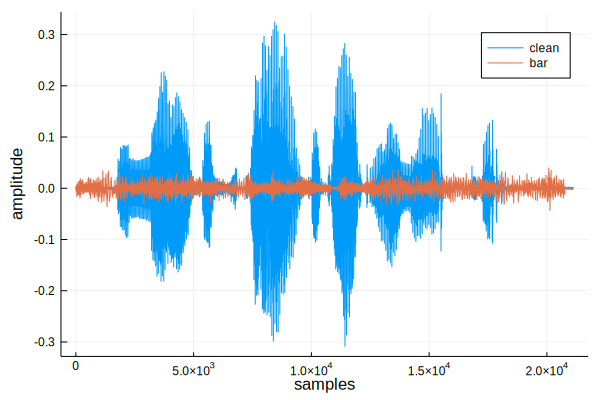

In [199]:
plot(cl, label=:clean)
plot!(get_signal(rmx, fs), label=:bar, ylabel="amplitude", xlabel="samples")

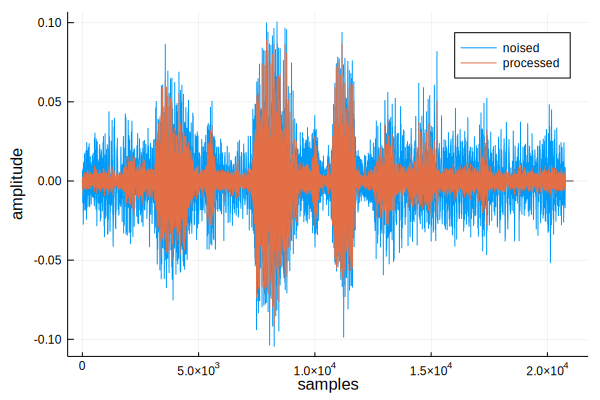

In [177]:
plot(get_signal(sb_seg, fs), label=:noised, ylabel="amplitude", xlabel="samples")
plot!(get_signal(rmz, fs), label=:processed)
# xlims!(5000,5100)

In [178]:
wavwrite(get_signal(rmz, fs), fs, "sound/processed/reconstructed_speech.wav")

In [179]:
wavwrite(get_signal(rmx, fs), fs, "sound/processed/reconstructed_bar.wav")

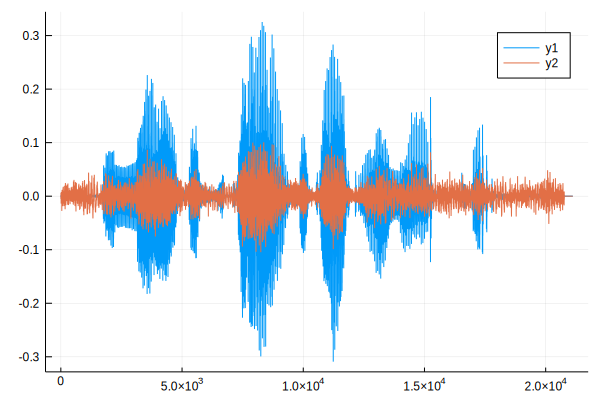

In [200]:
plot(get_signal(cl_seg, fs))
plot!(get_signal(sb_seg, fs))
# plot!(get_signal(rmx, fs))

In [196]:
# load clean speech
cl, fs = wavread("sound/speech/sp02.wav");
cl_seg = get_frames(cl, fs)

352×80 Matrix{Float64}:
  0.000885037   0.00122074    0.000488296  …  -0.000274667  -3.05185e-5
  0.000488296  -0.000152593  -0.00021363      -0.000183111  -3.05185e-5
  0.0           0.000244148   6.1037e-5        9.15555e-5    9.15555e-5
 -6.1037e-5    -0.000305185  -0.000183111      0.000366222   3.05185e-5
  0.000244148   0.000305185   0.0              0.00021363   -0.000152593
  0.000183111  -0.000244148   0.000122074  …   0.000244148   3.05185e-5
  9.15555e-5   -0.000305185   0.0             -0.000915555  -0.000518815
 -0.000366222  -0.000244148   0.000366222      3.05185e-5    0.000122074
  0.000244148   9.15555e-5   -0.000396741      0.000152593   0.000396741
  0.00021363    0.000152593   0.000335704     -0.000244148  -9.15555e-5
  0.000183111   0.000427259   0.000427259  …  -0.00021363   -0.000274667
 -0.000152593  -0.000457778  -0.000579852      9.15555e-5   -6.1037e-5
 -0.000183111  -0.000518815  -0.000274667     -9.15555e-5    6.1037e-5
  ⋮                                  

In [189]:
# to fix (not correct)
snr_before = SNR(get_signal(cl_seg, fs), get_signal(sb_seg, fs))

2.620459269534628

In [190]:
snr_after = SNR(get_signal(cl_seg, fs), get_signal(rmz, fs))

2.0695422230825233

In [186]:
SNR_gain = snr_after - snr_before

-2.0537984763753165